<img src="../images/vegan-logo-resized.png" style="float: right; margin: 10px;">

# Exploratory Data Analysis

Author: Gifford Tompkins

---

Project 03 | Notebook 2 of 6

## OBJECTIVE
This notebook will establish a Base Model to compare our final model's success to. We will then clean the data and make it ready fro analysis. We will then begin some Exploratory Data Analysis and attempt to get a sense of whether or not we will be able to answer our problem statement given our body of data. If so, we will also have a sense for how to develop a strategy for building our model.

# Import Libraries and Dataset

In [8]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from project_functions.model_tuning import condenser_tr, parse_performance

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [9]:
data_csv = '../data/data.csv'

# Exploratory Data Analysis
We are finished cleaning our data, so now we will explore it with some preliminary Vectorizations and develop a strategy for building our models.

In [10]:
eda = pd.read_csv(data_csv)
eda.head()

,title,selftext,vegan,removed,text
0,Lentil soup with sliced Beyond Meat sausage ta...,NaN,0,0,lentil soup with sliced beyond meat sausage ta...
1,Recipes for thanksgiving?,Hi! My bf’s sister is hosting thanksgiving thi...,0,0,recipe for thanksgiving hi my bfs sister is ...
2,What Happens IMMEDIATELY After You Die?? The T...,[https://www.youtube.com/watch?v=Dyvl\_8SoAjc...,0,0,what happens immediately after you die the t...
3,Vegetarian Chili for a cold October evening,NaN,0,0,vegetarian chili for a cold october evening
4,Any suggestions for vegetarian meal delivery s...,NaN,0,1,any suggestion for vegetarian meal delivery se...


In [11]:
eda['text'].isnull().mean()

0.0

## CountVectorizer
We will use a count vectorization to see if we can spot some features that will give us some signal and or detect some terms that are just giving us noise. For starters, we will give it the following parameters:
1. `stop_words` are english.
2. `ngram_range` from 1 to 2 word phrases.
3. `max_features` will be 2000.

In [12]:
cvec = CountVectorizer(stop_words='english',
                       ngram_range=(1,2),
                       max_features=2000)

In [13]:
term_cvec_matrix = cvec.fit_transform(eda['text'])

In [14]:
# Convert term matrix to a dataframe.
term_cvec_df = pd.DataFrame(term_cvec_matrix.toarray(), index=eda.index, columns=cvec.get_feature_names())

In [15]:
term_cvec_df.head()

,000,09,10,10 year,100,100 vegan,11,12,13,14,...,yogurt,york,young,youtu,youtube,youtube com,yum,yummy,zero,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,2,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Append the target column
term_cvec_df['vegan_target'] = eda['vegan']

In [17]:
term_cvec_df.head()

,000,09,10,10 year,100,100 vegan,11,12,13,14,...,york,young,youtu,youtube,youtube com,yum,yummy,zero,zucchini,vegan_target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
cvec_terms_by_target = term_cvec_df.groupby(by='vegan_target').agg(np.mean).T.sort_values(by=0,ascending=False)
cvec_terms_by_target

vegan_target,0,1
vegetarian,0.654742,0.066163
meat,0.509897,0.228374
im,0.448557,0.306386
ha,0.387732,0.342351
wa,0.318454,0.234455
...,...,...
nlm,0.000000,0.006082
nih gov,0.000000,0.006291
nih,0.000000,0.006291
ncbi nlm,0.000000,0.006082


###  CountVectorizer Signal Column
I am going to create a `'signal'` column that shows the difference in mean term frequency between the vegan posts and vegetarian posts. I will look at words with the highest signal for both r/Vegan and r/Vegetarian as well as some words that might be considered noise.

In [19]:
cvec_terms_by_target['signal'] = cvec_terms_by_target[1] - cvec_terms_by_target[0]
cvec_terms_by_target = cvec_terms_by_target.sort_values(by='signal',ascending=False)

In [20]:
vegan_terms_cv = cvec_terms_by_target.head(50).index
vegetarian_terms_cv = cvec_terms_by_target.tail(50).index
print(vegan_terms_cv)
print(vegetarian_terms_cv)

Index(['vegan', 'animal', 'veganism', 'http', 'www', 'http www', 'people',
       'com', 'milk', 'plant', 'non vegan', 'human', 'world', 'non',
       'vegan food', 'product', 'vegan diet', 'leather', 'animal product',
       'climate', 'going vegan', 'cow', 'org', 'dog', 'im vegan', 'pig',
       'argument', 'ive vegan', 'say', 'study', 'watch', 'kill', 'industry',
       'went vegan', 'friend', 'vegan year', 'article', 'video', 'news',
       'vegan im', 'environment', 'pet', 'dairy', 'ha vegan', 'plant based',
       'new vegan', 'farm', 'climate change', 'shoe', 'company'],
      dtype='object')
Index(['lot', 'eat meat', 'month', 'vegetarian vegan', 'idea', 'potato',
       'vegetable', 'feel', 'x200b', 'tomato', 'easy', 'sauce', 'day', 'egg',
       'cheese', 'mushroom', 'rice', 'veg', 'fish', 'vegetarianism',
       'eating meat', 'salad', 'dish', 'week', 'cooking', 'dinner', 'really',
       'diet', 'food', 'protein', 'year', 'chicken', 'ha', 'time', 'cook',
       'bean', 'make

In [21]:
cvec_terms_by_target['signal'].describe()

count    2000.000000
mean       -0.002228
std         0.024245
min        -0.588579
25%        -0.003427
50%        -0.000881
75%         0.001262
max         0.706302
Name: signal, dtype: float64

> The words below might just be considered noise. They are the 100 words with the least amount of signal according to the CountVectorizer frequency.

In [22]:
cvec_term_mean = np.mean(cvec_terms_by_target['signal'])
cvec_term_std = np.std(cvec_terms_by_target['signal'])
cvec_noise = np.abs(cvec_terms_by_target['signal'] - cvec_term_mean).sort_values()[:100].index
cvec_noise

Index(['late', 'gym', 'literally', 'year im', 'day week', 'got', 'avoiding',
       'wondering ha', 'sour', 'dry', 'finish', 'cherry', 'dried', 'attempt',
       'mainly', 'id love', 'gross', 'place', 'really like', 'free', 'box',
       'looked', 'butter', 'eat ha', 'thing ive', 'wife', 'strip',
       'really know', 'chipotle', 'feel better', 'moving', 'nutrient',
       'typically', 'mashed', 'hey', 'asian', 'ordering', 'turning',
       'im hoping', 'various', 'meat burger', 'inspired', 'trying eat', '20',
       'need advice', 'amazing', 'sprout', 'im starting', 'ive got', 'open',
       'oatmeal', 'needed', 'really want', 'deal', 'unhealthy',
       'meat consumption', 'welcome', 'vegan vegetarian', 'impossible whopper',
       'taste like', 'slowly', 'transitioning', 'apple', 'shopping', 'proud',
       'mother', 'type', 'white', 'wrap', 'did think', 'balance', 'household',
       'lazy', 'tortilla', 'discovered', 'title say', 'middle', 'usual',
       'food im', 'pretty good', 

### Plot the Signal Words
Below is a heat map of the highest signal words.

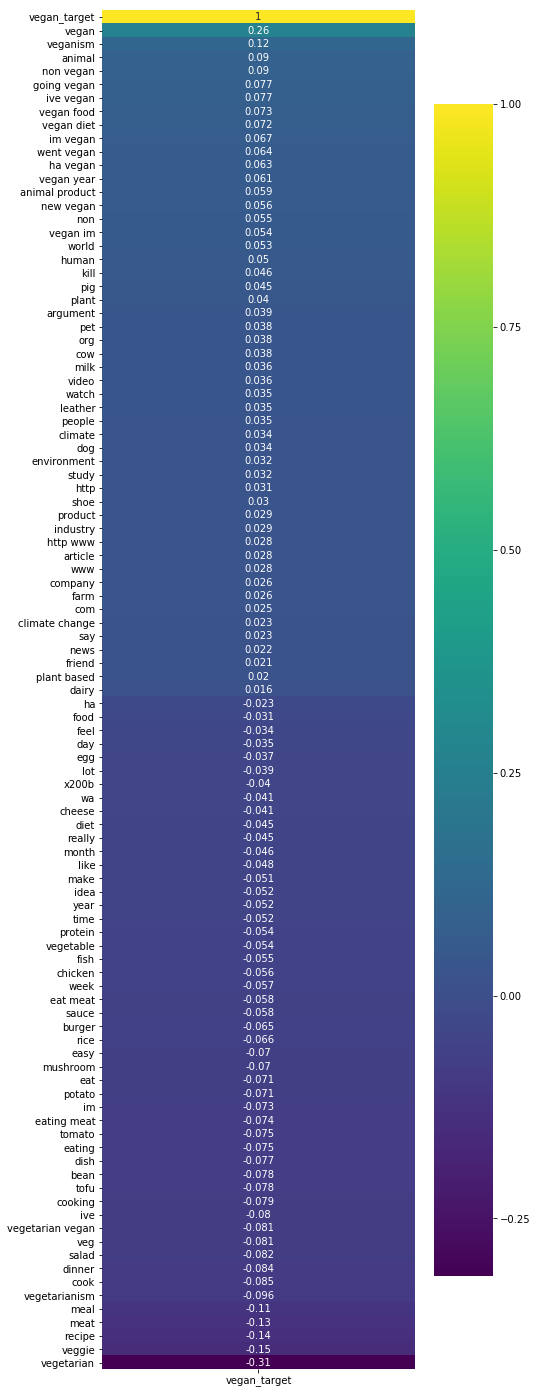

In [23]:
term_list_cv = [*vegan_terms_cv, *vegetarian_terms_cv, *['vegan_target']]

corr = term_cvec_df[term_list_cv].corr()[['vegan_target']].sort_values(by='vegan_target',
                                                               ascending=False)

plt.figure(figsize=(7,25))
sns.heatmap(corr,
            annot=True,
            cmap='viridis')

In [24]:
term_cvec_df[vegan_terms_cv].agg(np.sum)

vegan             10395
animal             3404
veganism            881
http               1843
www                1024
http www            996
people             2285
com                1194
milk               1143
plant              1131
non vegan           277
human               442
world               506
non                 596
vegan food          284
product            1167
vegan diet          280
leather             304
animal product      379
climate             310
going vegan         251
cow                 496
org                 205
dog                 397
im vegan            184
pig                 255
argument            267
ive vegan           136
say                1055
study               198
watch               280
kill                202
industry            408
went vegan          145
friend              876
vegan year          149
article             253
video               296
news                204
vegan im            180
environment         311
pet             

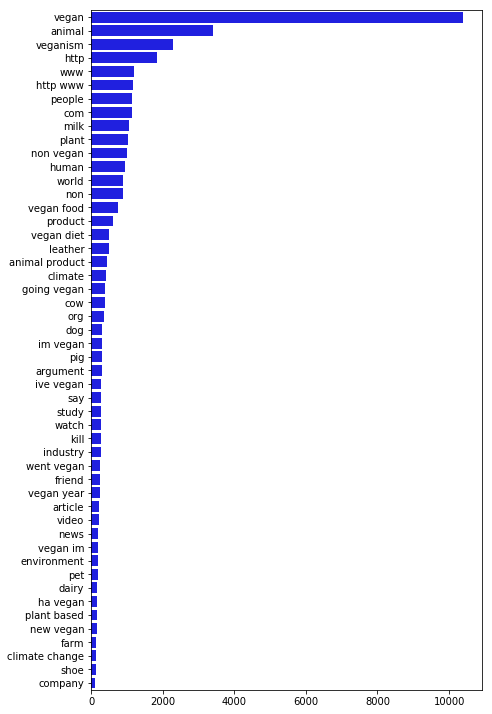

In [25]:
plt.figure(figsize=(7,12.5))
sns.barplot(x=term_cvec_df[vegan_terms_cv].agg(np.sum).sort_values(ascending=False),
            y=vegan_terms_cv,
            color='b',
            orient='h');

In [26]:
cvec_terms_by_target['class'] = cvec_terms_by_target['signal'].map(lambda x: 'vegan' if x > 0.001 else ('vegetarian' if x < -0.001 else 'ambiguous'))

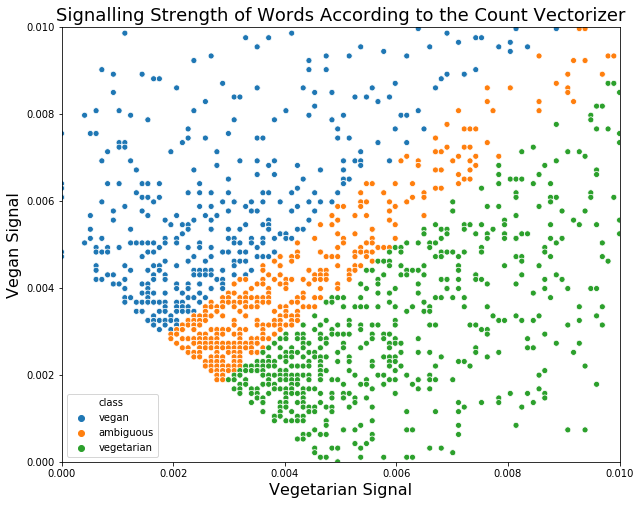

In [27]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=cvec_terms_by_target, x=0, y=1, hue='class')
plt.title('Signalling Strength of Words According to the Count Vectorizer', size=18)
plt.xlabel("Vegetarian Signal", size=16)
plt.ylabel("Vegan Signal", size=16)
plt.xlim((0,0.01))
plt.ylim((0,0.01))
plt.savefig('../images/vegan_v_vegetarian_signal.jpg')

## TFIDVectorizer
We will use a TF-IDF vectorization to see if we can spot some features that will give us some signal.

In [28]:
tfid = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,2),
                       max_features=2000)

In [29]:
term_tfid_matrix = tfid.fit_transform(eda['text'])

In [30]:
# Convert term matrix to a dataframe.
term_tfid_df = pd.DataFrame(term_tfid_matrix.toarray(), index=eda.index, columns=cvec.get_feature_names())

In [31]:
term_tfid_df.head()

,000,09,10,10 year,100,100 vegan,11,12,13,14,...,yogurt,york,young,youtu,youtube,youtube com,yum,yummy,zero,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.262723,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.321808,0.361812,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [32]:
# Append the target column
term_tfid_df['vegan_target'] = eda['vegan']

In [33]:
term_tfid_df.head()

,000,09,10,10 year,100,100 vegan,11,12,13,14,...,york,young,youtu,youtube,youtube com,yum,yummy,zero,zucchini,vegan_target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.262723,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.321808,0.361812,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0


In [34]:
tfid_terms_by_target = term_tfid_df.groupby(by='vegan_target').agg(np.mean).T.sort_values(by=0,ascending=False)
tfid_terms_by_target

vegan_target,0,1
vegetarian,0.062579,0.005066
meat,0.038292,0.022343
im,0.029280,0.022046
recipe,0.026057,0.007108
ha,0.025607,0.026564
...,...,...
nih gov,0.000000,0.000105
nih,0.000000,0.000105
ncbi,0.000000,0.000095
ncbi nlm,0.000000,0.000095


###  TfidfVectorizer Signal Column
I am going to create a `'signal'` column that shows the difference in mean TF-IDF score for the vegan posts and vegetarian posts. I will look at words with the highest signal for both r/Vegan and r/Vegetarian as well as some words that might be considered noise.

In [35]:
tfid_terms_by_target['signal'] = tfid_terms_by_target[1] - tfid_terms_by_target[0]
tfid_terms_by_target = tfid_terms_by_target.sort_values(by='signal',ascending=False)

In [36]:
vegan_terms_tf = tfid_terms_by_target.head(50).index
vegetarian_terms_tf = tfid_terms_by_target.tail(50).index
print(vegan_terms_cv)
print(vegetarian_terms_cv)

Index(['vegan', 'animal', 'veganism', 'http', 'www', 'http www', 'people',
       'com', 'milk', 'plant', 'non vegan', 'human', 'world', 'non',
       'vegan food', 'product', 'vegan diet', 'leather', 'animal product',
       'climate', 'going vegan', 'cow', 'org', 'dog', 'im vegan', 'pig',
       'argument', 'ive vegan', 'say', 'study', 'watch', 'kill', 'industry',
       'went vegan', 'friend', 'vegan year', 'article', 'video', 'news',
       'vegan im', 'environment', 'pet', 'dairy', 'ha vegan', 'plant based',
       'new vegan', 'farm', 'climate change', 'shoe', 'company'],
      dtype='object')
Index(['lot', 'eat meat', 'month', 'vegetarian vegan', 'idea', 'potato',
       'vegetable', 'feel', 'x200b', 'tomato', 'easy', 'sauce', 'day', 'egg',
       'cheese', 'mushroom', 'rice', 'veg', 'fish', 'vegetarianism',
       'eating meat', 'salad', 'dish', 'week', 'cooking', 'dinner', 'really',
       'diet', 'food', 'protein', 'year', 'chicken', 'ha', 'time', 'cook',
       'bean', 'make

In [37]:
tfid_terms_by_target['signal'].describe()

count    2000.000000
mean       -0.000244
std         0.002542
min        -0.057513
25%        -0.000536
50%        -0.000102
75%         0.000301
max         0.071800
Name: signal, dtype: float64

> The words below might just be considered noise. They are the 100 words with the least amount of signal according to the CountVectorizer frequency.

In [38]:
tfid_term_mean = np.mean(tfid_terms_by_target['signal'])
tfid_term_std = np.std(tfid_terms_by_target['signal'])
tfid_noise = np.abs(tfid_terms_by_target['signal'] - tfid_term_mean).sort_values()[:100].index
tfid_noise

Index(['omega', 'gotten', 'sure ha', 'need help', 'kidney', 'hungry', 'chick',
       'feedback', 'household', 'considered', 'ive decided', 'want make',
       'acne', 'ive recently', 'south', 'balance', 'grew', 'really like',
       'forgot', 'couple', 'orange', 'stuck', 'just wondering', 'looked',
       'hard', 'food eat', 'dry', 'ethical', 'possible', 'filled',
       'pretty good', 'asked', 'carnivore', 'transitioning', 'year im', 'kid',
       'glad', 'expensive', 'absolutely', 'sharing', 'wonderful',
       'recipe http', 'conscious', 'garden', 'did like', 'currently',
       'nutrition', 'wa hoping', '14', 'item', 'specific', 'inspiration',
       'anymore', 'rarely', 'giant', 'just eat', 'time week', 'did eat',
       'america', 'consuming', 'enjoyed', 'basic', 'normal', 'gram',
       'situation', 'later', 'totally', 'common', 'topic', 'lab', 'decent',
       'dad', 'transition', 'specifically', 'grain', 'just feel', 'tl',
       'month ago', 'eat im', 'pressure', 'type', 'ju

### Plot the Signal Words
Below is a heat map of the highest signal words.

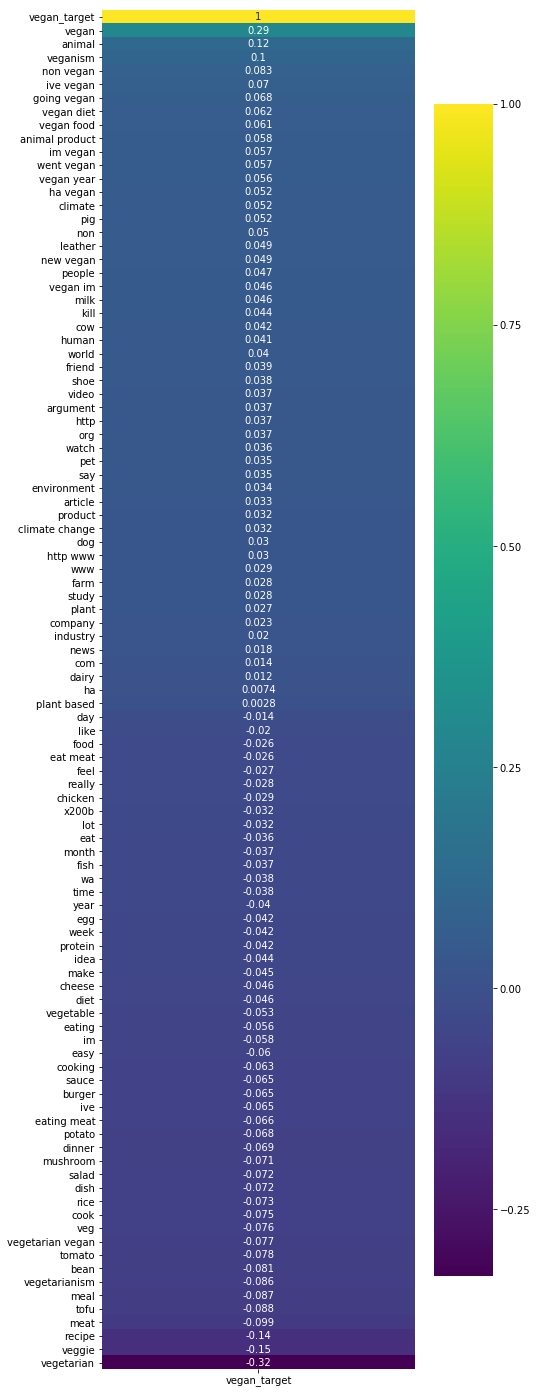

In [39]:
term_list_cv = [*vegan_terms_cv, *vegetarian_terms_cv, *['vegan_target']]

corr = term_tfid_df[term_list_cv].corr()[['vegan_target']].sort_values(by='vegan_target',
                                                               ascending=False)

plt.figure(figsize=(7,25))
sns.heatmap(corr,
            annot=True,
            cmap='viridis')

In [40]:
term_tfid_df[vegan_terms_cv].agg(np.sum)

vegan             1075.373442
animal             336.628465
veganism           136.735237
http               147.555192
www                 73.625873
http www            71.447508
people             215.980046
com                 98.836595
milk               141.199392
plant              164.046785
non vegan           46.447166
human               59.493727
world               92.864987
non                 82.848024
vegan food          57.848730
product            126.184079
vegan diet          46.566248
leather             45.117333
animal product      46.454985
climate             59.853580
going vegan         45.989122
cow                 91.267509
org                 17.683665
dog                 68.130081
im vegan            34.135557
pig                 67.214367
argument            39.795005
ive vegan           21.516490
say                126.920417
study               31.841326
watch               47.513179
kill                38.563340
industry            61.644281
went vegan

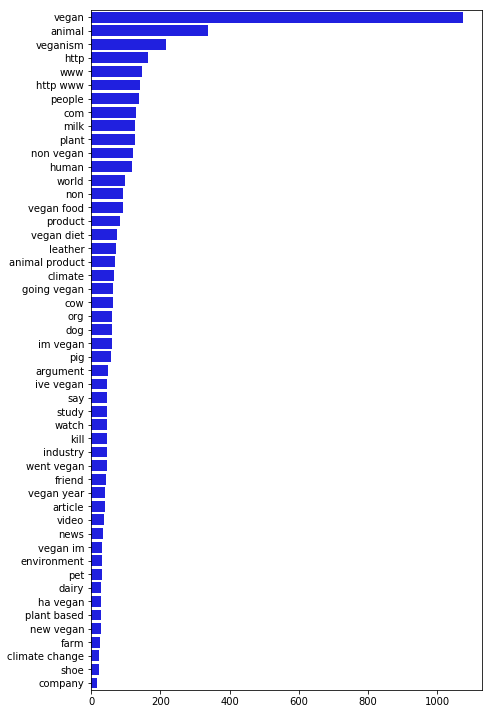

In [41]:
plt.figure(figsize=(7,12.5))
sns.barplot(x=term_tfid_df[vegan_terms_cv].agg(np.sum).sort_values(ascending=False),
            y=vegan_terms_cv,
            color='b',
            orient='h')

In [42]:
signal_terms = set([*vegan_terms_cv, *vegan_terms_tf, *vegetarian_terms_cv, *vegetarian_terms_tf])
signal_terms

{'activist',
 'animal',
 'animal product',
 'argument',
 'article',
 'bean',
 'burger',
 'cake',
 'cauliflower',
 'changer',
 'cheese',
 'chicken',
 'climate',
 'climate change',
 'com',
 'company',
 'cook',
 'cooking',
 'cow',
 'cream',
 'curry',
 'dairy',
 'day',
 'diet',
 'dinner',
 'dish',
 'dog',
 'easy',
 'eat',
 'eat meat',
 'eating',
 'eating meat',
 'egg',
 'environment',
 'farm',
 'feel',
 'fish',
 'food',
 'fried',
 'friend',
 'game changer',
 'going vegan',
 'good',
 'guy',
 'ha',
 'ha vegan',
 'homemade',
 'horse',
 'http',
 'http www',
 'human',
 'idea',
 'im',
 'im vegan',
 'impossible',
 'industry',
 'ive',
 'ive vegan',
 'kill',
 'leather',
 'lentil',
 'like',
 'look',
 'lot',
 'lunch',
 'make',
 'meal',
 'meat',
 'milk',
 'month',
 'mushroom',
 'new vegan',
 'news',
 'non',
 'non vegan',
 'onion',
 'org',
 'people',
 'pepper',
 'pet',
 'pig',
 'plant',
 'plant based',
 'potato',
 'product',
 'protein',
 'really',
 'recipe',
 'recipe comment',
 'rice',
 'right',
 'roas

In [44]:
mms = MinMaxScaler()
tfid_df = pd.DataFrame(tfid_terms_by_target['signal'],index=tfid_terms_by_target.index)
tfid_df['signal'] = mms.fit_transform(tfid_df[['signal']])
tfid_df.columns = ['tfid_signal']
tfid_df

,tfid_signal
vegan,1.000000
animal,0.566581
veganism,0.524779
people,0.479986
milk,0.479309
...,...
tofu,0.355572
meat,0.321418
veggie,0.305711
recipe,0.298228


In [45]:
cvec_df = pd.DataFrame(cvec_terms_by_target['signal'],index=cvec_terms_by_target.index)
cvec_df['signal'] = mms.fit_transform(cvec_df[['signal']])
cvec_df.columns = ['cvec_signal']
cvec_df

,cvec_signal
vegan,1.000000
animal,0.577303
veganism,0.508218
http,0.507748
www,0.491373
...,...
veggie,0.366419
recipe,0.349948
im,0.344748
meat,0.237130


# Model: Count Vectorizer

We will create a quick model here using the CountVectorizer and the Multinomial Naive Bayes estimator. We use the MultinomialNB because our values will be nonnegative integers after the CountVectorizer transforms our data.

We will also use a GridSearchCV to find the best parameters with which to tune our CountVectorizer.

In [46]:
pipe_cv = Pipeline([
    ('vec',CountVectorizer()),
    ('estimator', MultinomialNB())
])

In [47]:
X = eda['text']
y = eda['vegan']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

## Pipe Parameters

In [48]:
pipe_params = {
    'vec__max_features':[1000, 2000, 5000],
    'vec__min_df':[2, 3],
    'vec__max_df':[0.90, 0.95, 1.0],
    'vec__ngram_range': [(1,1), (1,2), (1,3)]
}

In [49]:
t_0 = time.time()
gs_cv = GridSearchCV(pipe_cv,
                     pipe_params,
                     cv=5,
                     n_jobs=-1                     
                 )
gs_cv.fit(X_train, y_train)

print(time.time() - t_0)

161.22565388679504


In [50]:
gs_cv.best_score_

gs_cv.best_params_

model_cv = gs_cv.best_estimator_
print(f"Training Score: {model_cv.score(X_train, y_train)}")
print(f"Testing score: {model_cv.score(X_test, y_test)}")

Training Score: 0.7737575379496777
Testing score: 0.7467775467775468


> Our model is slightly overfit, but already there is a **50% improvement** from our baseline model.

# Model: TfidfVectorizer and GaussianNB
For the TfidfVectorizer, we have to use the Gaussian Naive Bayes estimator, because our vectorizer outputs float values between 0 and 1. The vectorizer also puts out a sparse matrix, so we will use a custom function called `condenser_tr` to transform it into a dense matrix.

To see the custom function documentation, look [here](./project_functions/model_tuning.py).

In [51]:
# Create pipe-grid for TfidVectorizer()
pipe_tf = Pipeline([
    ('vec',TfidfVectorizer()),
    ('to_dense',condenser_tr),
    ('gaus',GaussianNB())
])

In [52]:
pipe_params = {
    'vec__max_features':[1000, 2000, 5000],
    'vec__min_df':[2, 3],
    'vec__max_df':[0.90, 0.95],
    'vec__ngram_range': [(1,1), (1,2)]
}

In [53]:
t_0 = time.time()
gs_tf = GridSearchCV(pipe_tf,
                     pipe_params,
                     cv=5,
                     n_jobs=-1)
gs_tf.fit(X_train, y_train)

print(time.time() - t_0)

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


97.3617537021637


In [54]:
gs_tf.best_score_

0.7167117210785333

In [55]:
gs_tf.best_params_

{'vec__max_df': 0.9,
 'vec__max_features': 2000,
 'vec__min_df': 3,
 'vec__ngram_range': (1, 2)}

In [56]:
model_tf = gs_tf.best_estimator_
model_tf.score(X_train, y_train)

0.7714701601164483

In [57]:
model_tf.score(X_test, y_test)

0.7039501039501039

## Evaluate first models
Finally, we will see which model gave us a better sensitivity and specificity score using the custom function `parse_performance`, whose documentation can be found [here](./project_functions/model_tuning.py).

In [58]:
parse_performance(gs_cv, X_test, y_test)

(0.7289640591966173, 0.7640081799591002, (1868, 577, 641, 1724))

In [59]:
parse_performance(gs_tf, X_test, y_test)

(0.7078224101479915, 0.7002044989775051, (1712, 733, 691, 1674))

> Given the current parameters, the CountVectorizer gives us a higher specificity score.

# Summary
In this notebook we did some exploratory data analysis and looked at some of our highest signaling words, as well as the comparative performance of the TfidfVectorizer against the CountVectorizer for our future models.

In the next notebook we will create our models and find the ones that perform best for our objective of creating a model with high accuracy, optimizing for sensitivity.